# Software Evolution - Practical Session
## Laws of software evolution, code counting, code duplication and dependency analysis
## Academic year 2022-2023

### Write your answers under the questions that are present in this notebook  

### Read Section 1 and Section 2 in the provided description document before proceeding with the following section 

In [2]:
import os
import json
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import math
from pandas import option_context
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime

## 2. Verifying laws of software evolution

In [3]:
#Enter the path where the Eucalyptus project is present
eucalyptus_project_path = '../eucalyptus'

### 2.1 Data prepocessing
1. Get all the tags present in the eucalyptus project using CLOC
2. Filter out the tags that do not correspond to official releases

Code hint:  
To get the tags that are present in the project - "command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)" | sort -r'"   
To read the terminal output - 'process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)'

In [4]:
# Your code here
command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)"|sort -r'

#Read terminal output
process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)

all_tags = [tag for tag in process.communicate()[0].decode('utf-8').split('\n')]

In [5]:
# Your tag filtering code here

major_minor_patch_versions = ['1.4','1.5.0','1.5.1','1.5.2','1.6.1','2.0.0','2.0.1','3.0.0','3.0.1','3.1.0','3.1.1','3.1.2','3.2.0','3.2.1',
                              '3.2.2','3.3.0','3.3.1','3.3.2','3.4.0','3.4.1','3.4.2','v4.0.0','v4.0.1','v4.0.2','v4.1.0','v4.1.1','v4.1.2',
                              'v4.2.0','v4.2.1','v4.2.2','v4.3.0','v4.3.1','v4.4.0','v4.4.1','v4.4.2']
major_minor_versions = ['1.4','1.5.0','1.6.1','2.0.0','3.0.0','3.1.0','3.2.0','3.3.0','3.4.0','v4.0.0','v4.1.0','v4.2.0','v4.3.0','v4.4.0']


### 2.2 Law of Increasing Growth
1. Fetch the required data (lines of code, blank lines, comment lines and number of files) for each tag along with their release date using CLOC
2. Separate the data as following (also mentioned in section 2.1 of the description document)  
    a) Consider all the three-component versions (major.minor.patch) - Dataset A  
    b) Consider only the minor versions (major.minor) - Dataset B  

Note: For example, if there exists any tag like 2.1.0.1, then you can consider it as 2.1.0 provided such a tag does not exist in the data. If both 2.1.0 and 2.1.0.1 exists, then you can ignore the latter 

Code hint:  
To set the project to a required tag - "command = f'git -C {project_path} reset --hard {tag}'"  
For each tag, pass the command to the terminal, invoke cloc tool to get the necessary data in the required format (json, md,...), read the terminal output and store the data

In [6]:
#Your code here  

def extract_data(tags):
    """Function to extract data from the git repository
    """
    df = pd.DataFrame(columns=['tag', 'releaseDate', 'nCodeLine', 'nBlankLine', 'nCommentLine', 'nFile'])
    for tag in tags:
        command = f'git -C {eucalyptus_project_path} reset --hard {tag}'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
        command = f'cloc {eucalyptus_project_path} --json'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
        output = process.communicate()[0].decode('utf-8')
        data = json.loads(output)
        nCodeLine = data['Java']['code']
        nBlankLine = data['Java']['blank']
        nCommentLine = data['Java']['comment']
        nFile = data['Java']['nFiles']
        command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)|%(creatordate:short)" | sort -r'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
        releaseDates = process.communicate()[0].decode('utf-8').split('\n')
        #Find the correct release date
        for releaseDate in releaseDates:
            releaseDate = releaseDate.split('|')
            if releaseDate[0] == tag:
                releaseDate = datetime.strptime(releaseDate[1], '%Y-%m-%d')
                break
        df = df.append({'tag': tag, 'releaseDate': releaseDate, 'nCodeLine': nCodeLine, 'nBlankLine': nBlankLine, 'nCommentLine': nCommentLine, 'nFile': nFile}, ignore_index=True)
    return df

In [7]:
# Your code here to get the versions of the form major.minor 
df = extract_data(major_minor_versions)


1 error:
Line count, exceeded timeout:  ../eucalyptus/net/globalnetwork.c


In [8]:
# Your code here to get the versions of the form major.minor.patch
df_patch = extract_data(major_minor_patch_versions)


1 error:
Line count, exceeded timeout:  ../eucalyptus/net/globalnetwork.c


In [9]:
print(df.head())

     tag releaseDate nCodeLine nBlankLine nCommentLine nFile
0    1.4  2009-01-06     21281       4076         6750   235
1  1.5.0  2009-02-18     29898       5458        13558   295
2  1.6.1  2009-11-05     44375       7477        27525   469
3  2.0.0  2010-06-05     47426       7042        24334   465
4  3.0.0  2012-02-07    108162      17384        39347  1092


In [10]:
#Convert releaseDate to datetime for plotting
df['releaseDate'] = pd.to_datetime(df['releaseDate'])
df_patch['releaseDate'] = pd.to_datetime(df_patch['releaseDate'])

#### Visualization
1. x-axis = version, y-axis = number  
    i) for tags of the type major.minor.patch  
    ii) for tags of the type major.minor  

2. x-axis = date, y-axis = number  
    i) for tags of the type major.minor.patch  
    ii) for tags of the type major.minor  

For easy comparison, place the plots with the versions on x-axis should be on the top (0,0) and (1,0) and their corresponding plots with date on the x-axis right below them (1,0) and (1,1) 

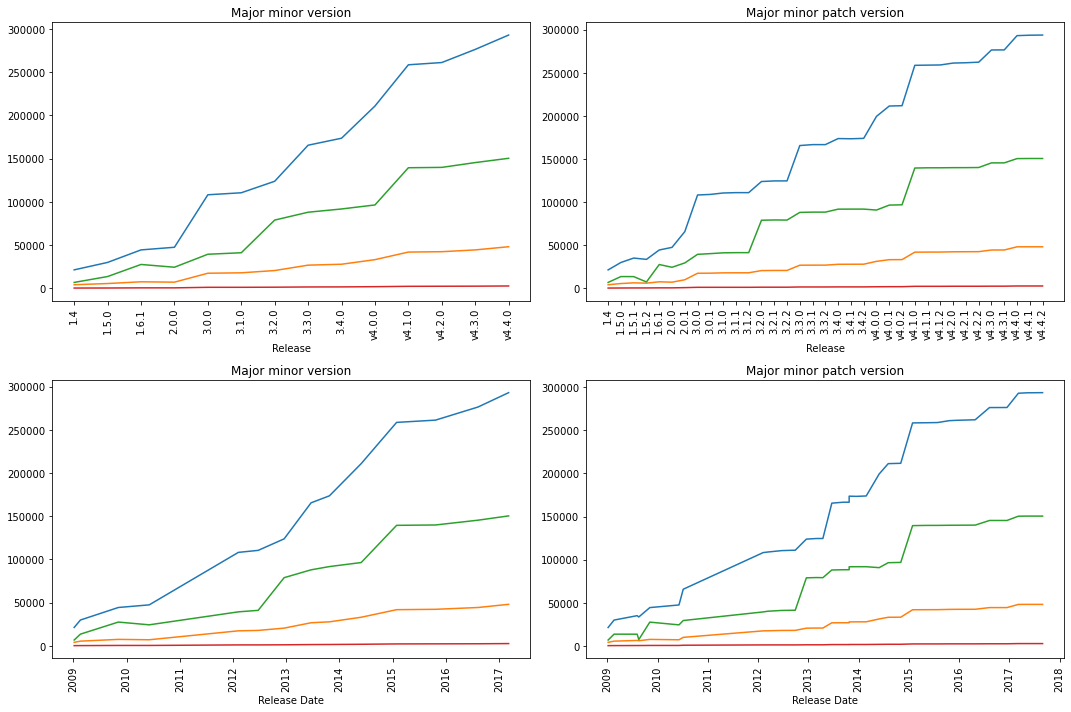

In [11]:
fig,axes = plt.subplots(2,2, figsize=(15, 10))

# Your plotting code here
axes[0,0].plot(df['tag'],df['nCodeLine'])
axes[0,0].plot(df['tag'],df['nBlankLine'])
axes[0,0].plot(df['tag'],df['nCommentLine'])
axes[0,0].plot(df['tag'],df['nFile'])
axes[0,0].set_title('Major minor version')
axes[0,0].set_xlabel('Release')
axes[0,0].tick_params(axis='x', rotation=90)

axes[0,1].plot(df_patch['tag'],df_patch['nCodeLine'])
axes[0,1].plot(df_patch['tag'],df_patch['nBlankLine'])
axes[0,1].plot(df_patch['tag'],df_patch['nCommentLine'])
axes[0,1].plot(df_patch['tag'],df_patch['nFile'])
axes[0,1].set_title('Major minor patch version')
axes[0,1].set_xlabel('Release')
axes[0,1].tick_params(axis='x', rotation=90)

axes[1,0].plot(df['releaseDate'],df['nCodeLine'])
axes[1,0].plot(df['releaseDate'],df['nBlankLine'])
axes[1,0].plot(df['releaseDate'],df['nCommentLine'])
axes[1,0].plot(df['releaseDate'],df['nFile'])
axes[1,0].set_title('Major minor version')
axes[1,0].set_xlabel('Release Date')
axes[1,0].tick_params(axis='x', rotation=90)

axes[1,1].plot(df_patch['releaseDate'],df_patch['nCodeLine'])
axes[1,1].plot(df_patch['releaseDate'],df_patch['nBlankLine'])
axes[1,1].plot(df_patch['releaseDate'],df_patch['nCommentLine'])
axes[1,1].plot(df_patch['releaseDate'],df_patch['nFile'])
axes[1,1].set_title('Major minor patch version')
axes[1,1].set_xlabel('Release Date')
axes[1,1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### Questions:
1. Do you find any difference between the plot that is having date in the x-axis and the plot that is having tag in the x-axis? If yes, then what is the difference? If no, then why is it same?

Yes, there is a small difference due to the fact that the plots with release date take into account the scale of time.

2. Which type of plot is preferable for software evolution analysis?   
    a) date in x-axis  
    b) tag in x-axis  
Why?

a) date in x-axis, because thanks to the scale of time, we can see better the evolution over time no matter the fact that many versions can be released in a small range of time.

3. Choose an option regarding the growth of the software by considering Dataset A. Motivate your choice using a 1d regression plot (below).  
    a) Linear  
    b) Sub-linear  
    c) Super-linear  

We can see in the 1d regression that the growths are linear.

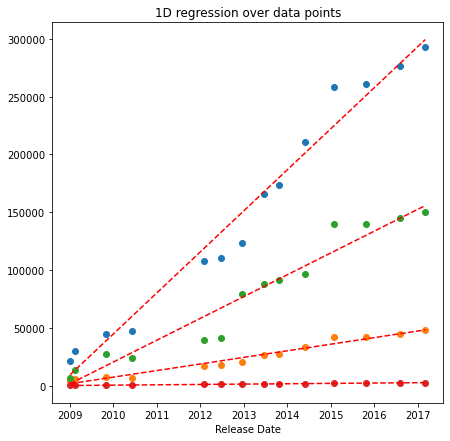

In [12]:
import matplotlib.dates as mdates

plt.figure(figsize=(7,7))
plt.title('1D regression over data points')

def plot_regression(x, y):
    plt.scatter(df['releaseDate'],y)
    y = y.astype('int64')
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")

plot_regression(mdates.date2num(df['releaseDate']), df['nCodeLine'])
plot_regression(mdates.date2num(df['releaseDate']), df['nBlankLine'])
plot_regression(mdates.date2num(df['releaseDate']), df['nCommentLine'])
plot_regression(mdates.date2num(df['releaseDate']), df['nFile'])

plt.xlabel('Release Date')

plt.show()

### Correlation 
Correlation is generally used to analyse the relationship between variables. Here, analyse the relationship between the number of lines of code and the number of files using Spearman correlation and Pearson correlation by considering Dataset A. Report the correlation upto 3 decimal places

In [13]:
# Your code for correlation
def spearman_correlation(x, y):
    return round(x.corr(y, method='spearman'),3)

def pearson_correlation(x, y):
    return round(x.corr(y, method='pearson'),3)

#Needed for the pearson correlation
df['nCodeLine'] = df['nCodeLine'].astype('float64')
df['nFile'] = df['nFile'].astype('float64')

print("Spearman : " + str(spearman_correlation(df['nCodeLine'], df['nFile'])))
print("Pearson : " + str(pearson_correlation(df['nCodeLine'], df['nFile'])))

Spearman : 0.996
Pearson : 0.998


### Questions:
4. Do you find any difference in correlation values between Pearson and Spearman? Which one is preferable for this use case? why?

Pearson's method only works with a linear relationship between the variables, whereas Spearman's method also works with a monotonic relationship. So in our case, Pearson's method is better because all the variable grows linearly.

5. Based on the above correlation value, how much is the number of lines of code related to the number of files?

99.9%

### Prediction
Consider Dataset A for this task. Drop the last two data points in "number of lines of code" (LOC) (i.e. drop (LOC) corresponding to v4.4.1 and v4.4.2) and forecast the values for (LOC) for v4.4.1 and v4.4.2 using a basic linear/polynimial regression model.
1. Drop the last two data points
2. Build a basic regression model
3. Ask the model to forecast the next two data points
4. Plot the LOC original and forecasted in the same plot. x-axis = date, y-axis = number of lines of code

In [14]:
# Your code here
df_test = df_patch.drop(df_patch.index[:-2])
df_train = df_patch.drop(df_patch.index[-2:])

In [15]:
# Your code here
X = mdates.date2num(df_train['releaseDate']).reshape(-1,1)
y = df_train['nCodeLine'].values
X_test = mdates.date2num(df_test['releaseDate']).reshape(-1,1)
y_test = df_test['nCodeLine'].values


In [16]:
# Your code here
best_r2 = - np.inf
best_k = 0
for k in range(10):
    poly = PolynomialFeatures(degree=k, include_bias=True)
    x_train_trans = poly.fit_transform(X)
    x_test_trans = poly.fit_transform(X_test)

    lr = LinearRegression()
    lr.fit(x_train_trans, y)
    y_pred = lr.predict(x_test_trans)

    r2 = r2_score(y_test, y_pred)
    if r2 > best_r2:
        best_r2 = r2
        best_k = k

print("Best k : " + str(best_k))
print("Best r2 : " + str(best_r2))

Best k : 4
Best r2 : -82.55920448123925


In [17]:
poly = PolynomialFeatures(degree=best_k, include_bias=True)
x_train_trans = poly.fit_transform(X)
x_test_trans = poly.fit_transform(X_test)

lr = LinearRegression()
lr.fit(x_train_trans, y)
y_pred = lr.predict(x_test_trans)

print("RMSE : " + str(np.sqrt(mean_squared_error(y_test, y_pred))))

RMSE : 813.555442914554


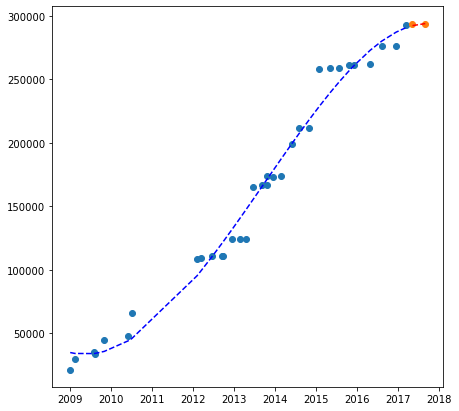

In [18]:
# Your plotting code here
plt.figure(figsize=(7,7))

plt.scatter(df_train['releaseDate'],df_train['nCodeLine'])
plt.scatter(df_test['releaseDate'],df_test['nCodeLine'])
plt.plot(df_train['releaseDate'],lr.predict(x_train_trans),'b--')
plt.plot(df_test['releaseDate'],y_pred,'r--')

plt.show()

### Questions:
6. What is the polynomial degree that you adopted to build the model? Why? 

I choose a polynomial degree of 4 because this gives the best R2.

7. What is the coefficient of determination? (R-squared)

R2 = -82.55

8. What is the Root mean square error for the forecasted values?

RMSE = 813.55

### Filtering on coding langugage

Consider the prominent langugages used in this software project and plot the distribution of their LOC in a pie chart for the first and the last versions

In [19]:
# Your code to get the data for LOC of first and last versions
first_version = major_minor_patch_versions[0]
last_version = major_minor_patch_versions[-1]

def plot_pie_chart(version, k):
    
    command = f'git -C {eucalyptus_project_path} reset --hard {version}'
    process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    command = f'cloc {eucalyptus_project_path} --json'
    process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    output = process.communicate()[0].decode('utf-8')
    data = json.loads(output)

    keys = data.keys()
    
    languages = list(keys)[1:-1]
    languages.remove("Bourne Shell")
    languages.remove("XML")
    languages.remove("Web Services Description")
    languages.remove("C/C++ Header")
    languages.remove("Ant")
    languages.remove("make")
    languages.remove("Bourne Again Shell")
    languages.remove("m4")
    languages.remove("diff")

    if version == first_version:
        languages.remove("XSD") 
        languages.remove("Drools")  
         
    # Your pie chart code here
    loc = []
    for language in languages[:k]:
        loc.append(data[language]['code'])

    plt.figure(figsize=(7,7))
    plt.pie(loc, labels=languages[:k], autopct='%1.1f%%')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
    plt.title(f'LOC of version {version} in top {k} languages')
    plt.show()

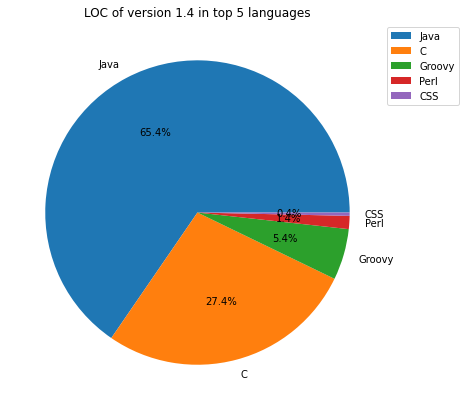

In [20]:
plot_pie_chart(first_version, 5)

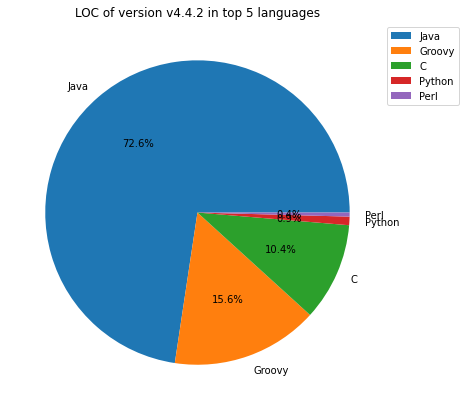

In [21]:
plot_pie_chart(last_version, 5)

### Question:
9. Do you find any significant difference in the distribution of the language used in the software project between its first and the last version? If so, what is the difference and how much is it?

Yes, the use of Java has increased from 65.4% to 69.5% and Python appears with a use of 0.9%. The use of C has decreased from 27.4% to 16.5%.

### Law of increasing growth for coding langugages

Get the LOC for each of the considered prominent langugages (as above) for each version of the form major.minor.patch  
1) Plot the date (x-axis) vs LOC (y-axis) 
2) Plot the date (x-axis) vs proportional LOC (y-axis). Proportional is LOC of a language/total number of LOC

In [31]:
# Your code to get the LOC for each prominent language of each version
def extract_data(tags, prominent_languages):
    #Dataframe to store the data
    df_dict = {}
    for language in prominent_languages:
        df_dict[language] = pd.DataFrame(columns=['tag', 'releaseDate', 'code', 'comment', 'blank'])
    for tag in tags:
        command = f'git -C {eucalyptus_project_path} reset --hard {tag}'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
        command = f'cloc {eucalyptus_project_path} --json'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
        output = process.communicate()[0].decode('utf-8')
        data = json.loads(output)

        command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)|%(creatordate:short)" | sort -r'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
        releaseDates = process.communicate()[0].decode('utf-8').split('\n')
        for releaseDate in releaseDates:
            releaseDate = releaseDate.split('|')
            if releaseDate[0] == tag:
                releaseDate = datetime.strptime(releaseDate[1], '%Y-%m-%d')
                break

        for language in prominent_languages:
            if language in data.keys():
                code = data[language]['code']
                comment = data[language]['comment']
                blank = data[language]['blank']
                df_dict[language] = df_dict[language].append({'tag': tag, 'releaseDate': releaseDate, 'code': code, 'comment': comment, 'blank': blank}, ignore_index=True)
            else :
                df_dict[language] = df_dict[language].append({'tag': tag, 'releaseDate': releaseDate, 'code': 0, 'comment': 0, 'blank': 0}, ignore_index=True)
        
    return df_dict

In [32]:
# Your plotting code here
prominent_languages = ["Java", "C", "Groovy", "Perl", "Python"]
df_dict = extract_data(major_minor_patch_versions, prominent_languages)

Use of uninitialized value in concatenation (.) or string at /usr/bin/cloc line 5946.

1 error:
Line count, exceeded timeout:  ../eucalyptus/net/globalnetwork.c


In [33]:
for language in prominent_languages:
    df_dict[language]["Total"] = df_dict[language]["code"] + df_dict[language]["comment"] + df_dict[language]["blank"]

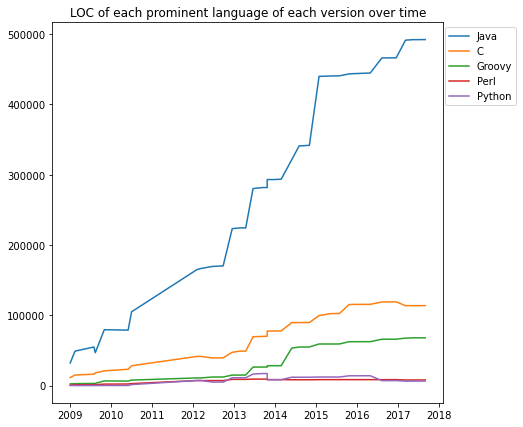

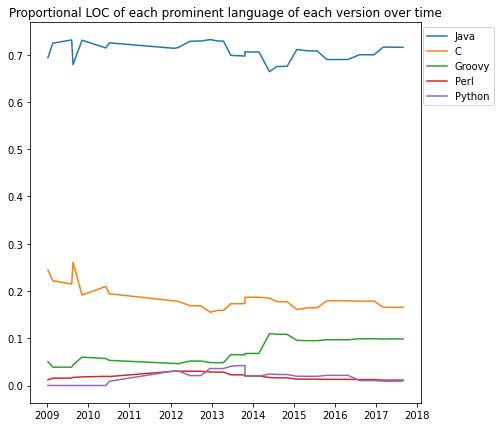

In [34]:
#plot the line chart
plt.figure(figsize=(7,7))
plt.title("LOC of each prominent language of each version over time")
for language in prominent_languages:
    plt.plot(df_dict[language]['releaseDate'],df_dict[language]['Total'],label=language)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

#Computing the proportional LOC
df_dict['total'] = df_dict['Java']['Total'] + df_dict['C']['Total'] + df_dict['Groovy']['Total'] + df_dict['Perl']['Total'] + df_dict['Python']['Total']
for language in prominent_languages:
    df_dict[language]['Prop'+language] = df_dict[language]['Total']/df_dict['total']

plt.figure(figsize=(7,7))
plt.title("Proportional LOC of each prominent language of each version over time")
for language in prominent_languages:
    plt.plot(df_dict[language]['releaseDate'],df_dict[language]['Prop'+language],label=language)

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

### Question:
10. Does the prominent languages considered by you obey laws of increasing growth?

Yes, we can observe that except for python and perl that represent less than two percent of the project, the other three prominent languages obey this law due to the linear increase of their LOC.

11. Does this software project obey the Law of Increasing Growth?

Yes, the language whose LOC increases the most (JAVA) represents up to 76% of the project.

### Modify the CLOC parameters

1. Exclude all bank lines and verify if the Law of Increasing Growth still holds good for this filtering

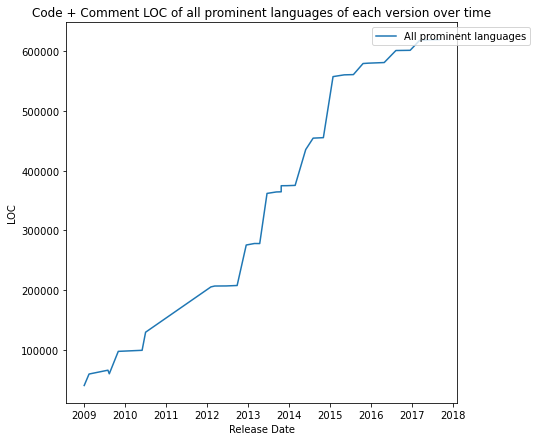

In [35]:
# Your code and plot here
for language in prominent_languages : 
    df_dict[language]['CodeComment'] = df_dict[language]['code'] + df_dict[language]['comment']

df_dict["total"]["CodeComment"] = df_dict["Java"]['CodeComment'] + df_dict["C"]['CodeComment'] + df_dict["Groovy"]['CodeComment'] + df_dict["Perl"]['CodeComment'] + df_dict["Python"]['CodeComment']
df_dict["total"]["releaseDate"] = df_dict["Java"]['releaseDate']

plt.figure(figsize=(7,7))
plt.title("Code + Comment LOC of all prominent languages of each version over time")
plt.plot(df_dict['total']['releaseDate'],df_dict['total']['CodeComment'],label='All prominent languages')

plt.xlabel('Release Date')
plt.ylabel('LOC')

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

2. Exclude all comment lines and verify if the Law of Increasing Growth still holds good for this filtering

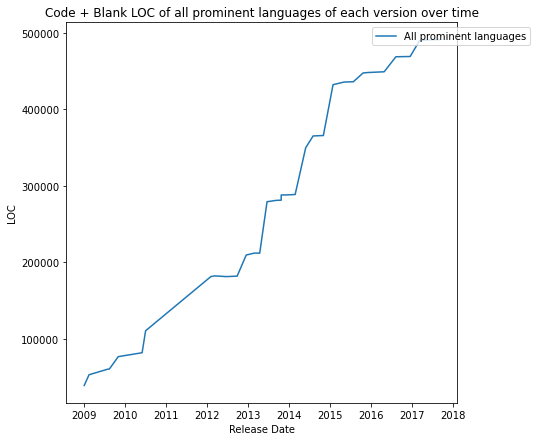

In [36]:
# Your code and plot here
for language in prominent_languages :
    df_dict[language]['CodeBlank'] = df_dict[language]['code'] + df_dict[language]['blank']

df_dict['total']['CodeBlank'] = df_dict['Java']['CodeBlank'] + df_dict['C']['CodeBlank'] + df_dict['Groovy']['CodeBlank'] + df_dict['Perl']['CodeBlank'] + df_dict['Python']['CodeBlank']

plt.figure(figsize=(7,7))
plt.title("Code + Blank LOC of all prominent languages of each version over time")
plt.plot(df_dict['total']['releaseDate'],df_dict['total']['CodeBlank'],label='All prominent languages')

plt.xlabel('Release Date')
plt.ylabel('LOC')

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

3. Exclude all non-code files (or consider prominent coding langugages used in the project) and and verify if the Law of Increasing Growth still holds good for this filtering

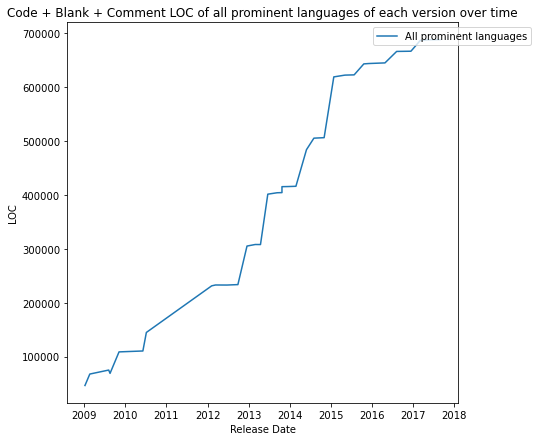

In [38]:
# Your code and plot here
df_dict['total']['Total'] = df_dict['Java']['Total'] + df_dict['C']['Total'] + df_dict['Groovy']['Total'] + df_dict['Perl']['Total'] + df_dict['Python']['Total']

plt.figure(figsize=(7,7))
plt.title("Code + Blank + Comment LOC of all prominent languages of each version over time")
plt.plot(df_dict['total']['releaseDate'],df_dict['total']['Total'],label='All prominent languages')
plt.xlabel('Release Date')
plt.ylabel('LOC')

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

We can see that the law is valid for all these 3 filters.

### 2.3 Law of Continuing Change
1. Using CLOC tool, find the features such as number of lines of code that are added, modified, removed and same between two consecutive versions
2. Consider all the three component versions (major.minor.patch) - Dataset A
3. Consider only the minor versions (major.minor) - Dataset B
4. Having all the features in the same plot, create two plots (one for Dataset A and another for Dataset B) the outcomes with date on x-axis and the number on y-axis.
5. Make a subplot of all the features

Code hint:  
For each pair of tags, set the original project to the required tag and the copy of the original project to the next tag.  
To get the required data in json format - "command = f'CLOC/cloc --git --diff {first_project_path} {second_project_path} --json'"

In [39]:
eucalyptus_project_path = '../eucalyptus' # your project path here
eucalyptus_copy_project_path = '../eucalyptus_copy' # your path to the copy of your project here

In [40]:
# Your code here to get the data
def extract_data_diffs(tags, prominent_languages):
    df = pd.DataFrame(columns=['releaseDate', 'tag', 'nextTag', 'added', 'same', 'modified', 'removed'])
    for i in range(len(tags)-1):
        tag = tags[i]
        nextTag = tags[i+1]

        command = f'git -C {eucalyptus_project_path} reset --hard {tag}'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)

        command = f'git -C {eucalyptus_copy_project_path} reset --hard {nextTag}'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)

        command = f'cloc --git --diff {eucalyptus_project_path} {eucalyptus_copy_project_path} --json'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)

        output = process.communicate()[0].decode('utf-8')

        data = json.loads(output)
        added = 0
        same = 0
        modified = 0
        removed = 0
        for language in prominent_languages:
            if language in data["added"].keys():
                added += data["added"][language]['code']
                same += data["same"][language]['code']
                modified += data["modified"][language]['code']
                removed += data["removed"][language]['code']

        command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)|%(creatordate:short)" | sort -r'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
        releaseDates = process.communicate()[0].decode('utf-8').split('\n')
        for releaseDate in releaseDates:
            releaseDate = releaseDate.split('|')
            if releaseDate[0] == tag:
                releaseDate = datetime.strptime(releaseDate[1], '%Y-%m-%d')
                break
            
        df = df.append({'releaseDate': releaseDate, 'tag': tag, 'nextTag': nextTag, 'added': added, 'same': same, 'modified': modified, 'removed': removed}, ignore_index=True)
    return df

In [41]:
prominent_languages = ['Java', 'C', 'Groovy', 'Perl', 'Python']
df = extract_data_diffs(major_minor_patch_versions, prominent_languages)


1 error:
Line count, exceeded timeout:  ../eucalyptus_copy/net/globalnetwork.c

1 error:
Line count, exceeded timeout:  ../eucalyptus/net/globalnetwork.c


In [42]:
df_B = extract_data_diffs(major_minor_versions, prominent_languages)


1 error:
Line count, exceeded timeout:  ../eucalyptus_copy/net/globalnetwork.c

1 error:
Line count, exceeded timeout:  ../eucalyptus/net/globalnetwork.c


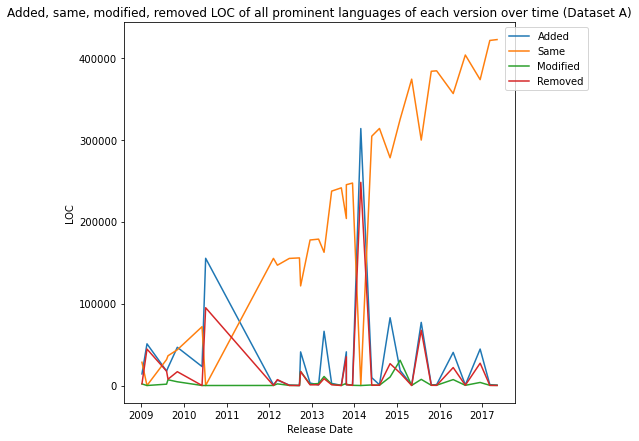

In [43]:
# Your plotting code here (all the features in a single plot)
plt.figure(figsize=(7,7))
plt.title("Added, same, modified, removed LOC of all prominent languages of each version over time (Dataset A)")
plt.plot(df['releaseDate'],df['added'],label='Added')
plt.plot(df['releaseDate'],df['same'],label='Same')
plt.plot(df['releaseDate'],df['modified'],label='Modified')
plt.plot(df['releaseDate'],df['removed'],label='Removed')

plt.xlabel('Release Date')
plt.ylabel('LOC')

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

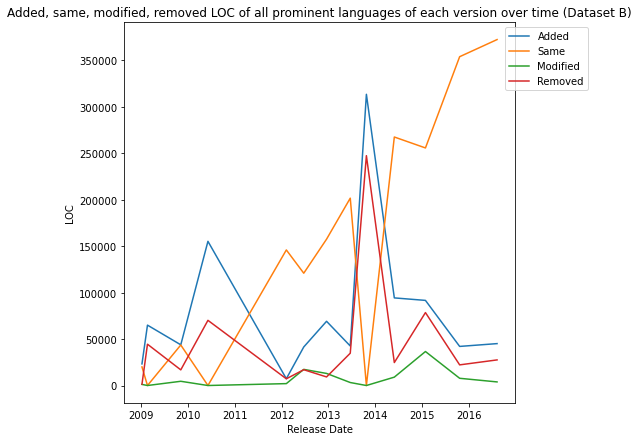

In [44]:
plt.figure(figsize=(7,7))
plt.title("Added, same, modified, removed LOC of all prominent languages of each version over time (Dataset B)")
plt.plot(df_B['releaseDate'],df_B['added'],label='Added')
plt.plot(df_B['releaseDate'],df_B['same'],label='Same')
plt.plot(df_B['releaseDate'],df_B['modified'],label='Modified')
plt.plot(df_B['releaseDate'],df_B['removed'],label='Removed')

plt.xlabel('Release Date')
plt.ylabel('LOC')

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

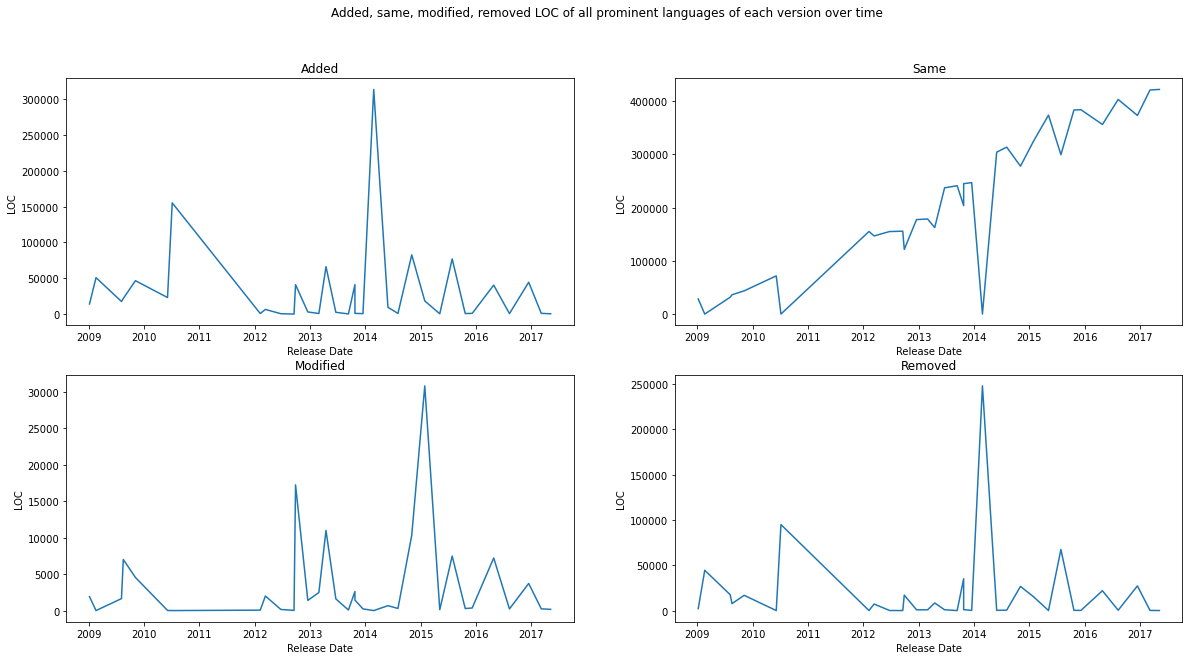

In [45]:
# Your plotting code here, different plot for each feature
fig,axes = plt.subplots(2,2, figsize=(20, 10))
fig.suptitle("Added, same, modified, removed LOC of all prominent languages of each version over time")

axes[0,0].plot(df['releaseDate'],df['added'],label='Added')
axes[0,0].set_title('Added')
axes[0,0].set_xlabel('Release Date')
axes[0,0].set_ylabel('LOC')

axes[0,1].plot(df['releaseDate'],df['same'],label='Same')
axes[0,1].set_title('Same')
axes[0,1].set_xlabel('Release Date')
axes[0,1].set_ylabel('LOC')

axes[1,0].plot(df['releaseDate'],df['modified'],label='Modified')
axes[1,0].set_title('Modified')
axes[1,0].set_xlabel('Release Date')
axes[1,0].set_ylabel('LOC')

axes[1,1].plot(df['releaseDate'],df['removed'],label='Removed')
axes[1,1].set_title('Removed')
axes[1,1].set_xlabel('Release Date')
axes[1,1].set_ylabel('LOC')

plt.show()

### Questions:
1. Do you find the Law of Continuing Change holding good here? Prove it empirically.

Yes, the law holds because we can observe that during the various patches, many lines of code are added, modified or deleted.

2. Does the law of increasing growth too hold good here?

Yes, we can see that there are more codes added than deleted.

### Law of continuing change for coding languages
Consider the prominent languages used in this software project for versions of the form major.minor.patch
1. Obtain the number of lines of code that are added, modified, removed and same between two consecutive versions
2. Make plots for each parameter (added, modified, removed and same) with date on x-axis  
    a) y-axis number of lines of code   
    b) y-axis proportional number of lines of code (number of lines of code of that language/total number of lines of code) 

In [46]:
# Your code here to get the data
def extract_data_diffs(tags, prominent_languages):
    df_dict = {}
    for language in prominent_languages:
        df_dict[language] = df = pd.DataFrame(columns=['releaseDate', 'tag', 'nextTag', 'added', 'same', 'modified', 'removed'])
    for i in range(len(tags)-1):
        tag = tags[i]
        nextTag = tags[i+1]

        command = f'git -C {eucalyptus_project_path} reset --hard {tag}'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)

        command = f'git -C {eucalyptus_copy_project_path} reset --hard {nextTag}'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)

        command = f'cloc --git --diff {eucalyptus_project_path} {eucalyptus_copy_project_path} --json'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)

        output = process.communicate()[0].decode('utf-8')

        data = json.loads(output)

        command = f'git -C {eucalyptus_project_path} tag -l --format="%(refname:short)|%(creatordate:short)" | sort -r'
        process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
        releaseDates = process.communicate()[0].decode('utf-8').split('\n')
        for releaseDate in releaseDates:
            releaseDate = releaseDate.split('|')
            if releaseDate[0] == tag:
                releaseDate = datetime.strptime(releaseDate[1], '%Y-%m-%d')
                break

        for language in prominent_languages:
            if language in data["added"].keys():
                added = data["added"][language]["code"]
                same = data["same"][language]["code"]
                modified = data["modified"][language]["code"]
                removed = data["removed"][language]["code"]
            else:
                added = 0
                same = 0
                modified = 0
                removed = 0

            df_dict[language] = df_dict[language].append({'releaseDate': releaseDate, 'tag': tag, 'nextTag': nextTag, 'added': added, 'same': same, 'modified': modified, 'removed': removed}, ignore_index=True)
    return df_dict

In [47]:
df_dict = extract_data_diffs(major_minor_patch_versions, prominent_languages)


1 error:
Line count, exceeded timeout:  ../eucalyptus_copy/net/globalnetwork.c

1 error:
Line count, exceeded timeout:  ../eucalyptus/net/globalnetwork.c


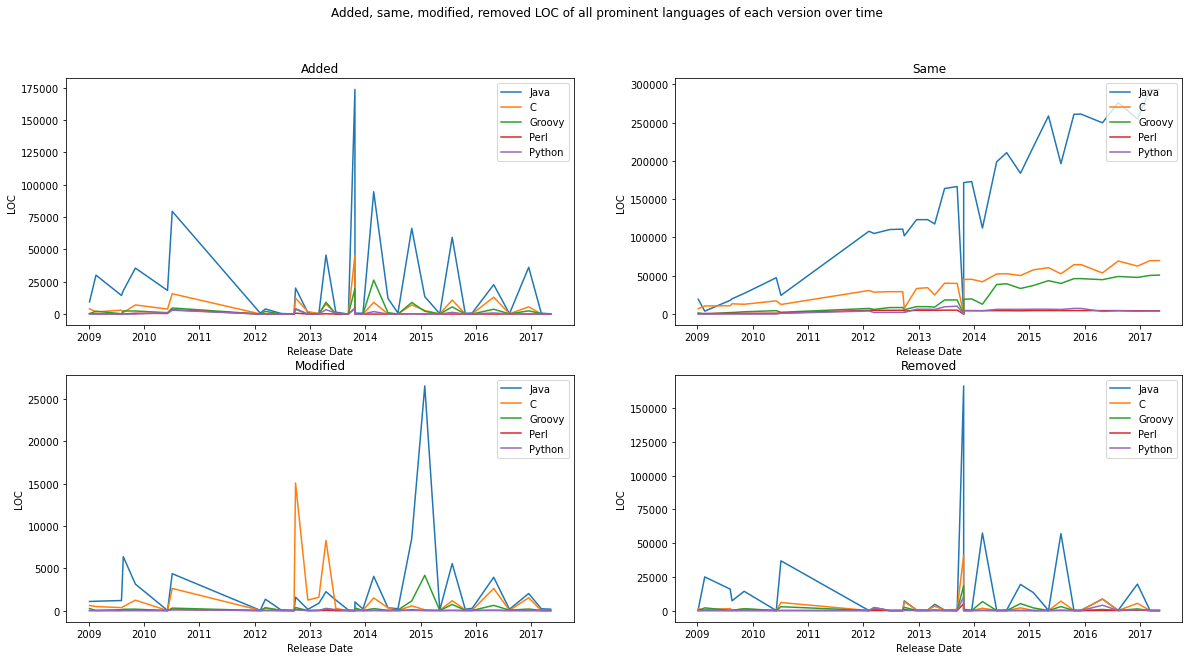

In [48]:
# Your plotting code here
fig,axes = plt.subplots(2,2, figsize=(20, 10))
fig.suptitle("Added, same, modified, removed LOC of all prominent languages of each version over time")

for language in prominent_languages:
    axes[0,0].plot(df_dict[language]['releaseDate'],df_dict[language]['added'],label=language)
    axes[0,1].plot(df_dict[language]['releaseDate'],df_dict[language]['same'],label=language)
    axes[1,0].plot(df_dict[language]['releaseDate'],df_dict[language]['modified'],label=language)
    axes[1,1].plot(df_dict[language]['releaseDate'],df_dict[language]['removed'],label=language)

axes[0,0].set_title('Added')
axes[0,0].set_xlabel('Release Date')
axes[0,0].set_ylabel('LOC')
axes[0,0].legend(loc='upper right')
axes[0,1].set_title('Same')
axes[0,1].set_xlabel('Release Date')
axes[0,1].set_ylabel('LOC')
axes[0,1].legend(loc='upper right')
axes[1,0].set_title('Modified')
axes[1,0].set_xlabel('Release Date')
axes[1,0].set_ylabel('LOC')
axes[1,0].legend(loc='upper right')
axes[1,1].set_title('Removed')
axes[1,1].set_xlabel('Release Date')
axes[1,1].set_ylabel('LOC')
axes[1,1].legend(loc='upper right')

plt.show()

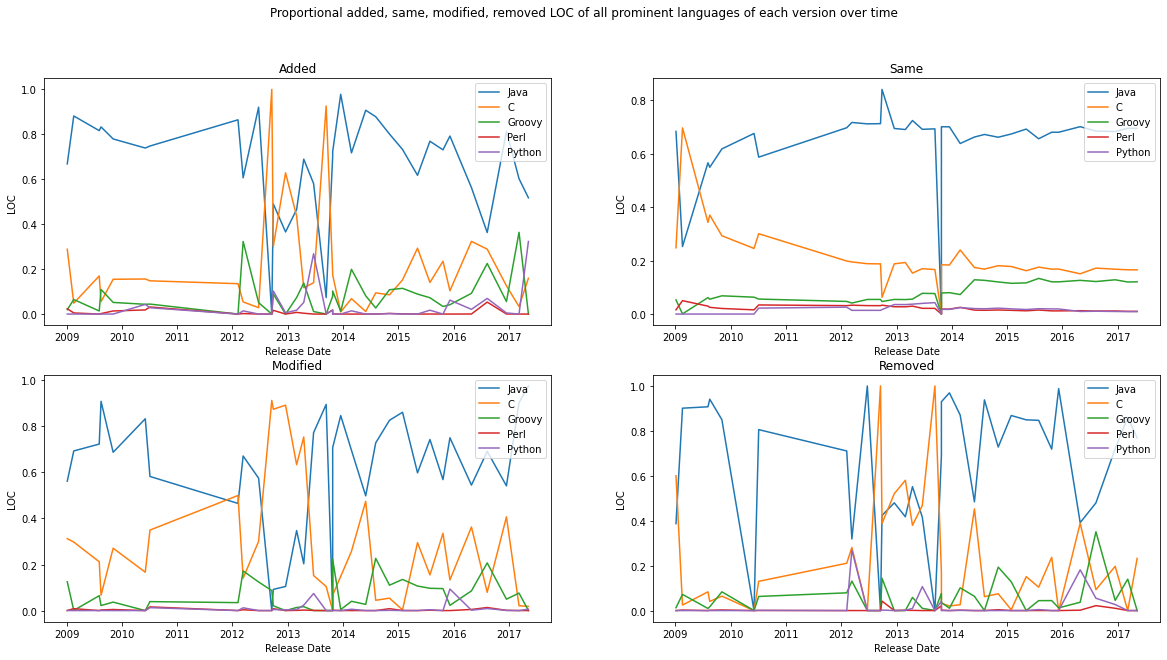

In [49]:
# Your plotting code here
prominent_languages = ['Java', 'C', 'Groovy', 'Perl', 'Python']

fig,axes = plt.subplots(2,2, figsize=(20, 10))
fig.suptitle("Proportional added, same, modified, removed LOC of all prominent languages of each version over time")

totalAdded = df_dict['Java']['added'] + df_dict['C']['added'] + df_dict['Groovy']['added'] + df_dict['Perl']['added'] + df_dict['Python']['added']
totalSame = df_dict['Java']['same'] + df_dict['C']['same'] + df_dict['Groovy']['same'] + df_dict['Perl']['same'] + df_dict['Python']['same']
totalModified = df_dict['Java']['modified'] + df_dict['C']['modified'] + df_dict['Groovy']['modified'] + df_dict['Perl']['modified'] + df_dict['Python']['modified']
totalRemoved = df_dict['Java']['removed'] + df_dict['C']['removed'] + df_dict['Groovy']['removed'] + df_dict['Perl']['removed'] + df_dict['Python']['removed']

for language in prominent_languages:
    added_proportional_value = []
    same_proportional_value = []
    modified_proportional_value = []
    removed_proportional_value = []

    for i in range(len(df_dict[language])):
        added_proportional_value.append(df_dict[language]['added'][i]/totalAdded[i] if totalAdded[i] != 0 else 0)
        same_proportional_value.append(df_dict[language]['same'][i]/totalSame[i] if totalSame[i] != 0 else 0)
        modified_proportional_value.append(df_dict[language]['modified'][i]/totalModified[i] if totalModified[i] != 0 else 0)
        removed_proportional_value.append(df_dict[language]['removed'][i]/totalRemoved[i] if totalRemoved[i] != 0 else 0)

    axes[0,0].plot(df_dict[language]['releaseDate'],added_proportional_value,label=language)
    axes[0,1].plot(df_dict[language]['releaseDate'],same_proportional_value,label=language)
    axes[1,0].plot(df_dict[language]['releaseDate'],modified_proportional_value,label=language)
    axes[1,1].plot(df_dict[language]['releaseDate'],removed_proportional_value,label=language)
    
axes[0,0].set_title('Added')
axes[0,0].set_xlabel('Release Date')
axes[0,0].set_ylabel('LOC')
axes[0,0].legend(loc='upper right')

axes[0,1].set_title('Same')
axes[0,1].set_xlabel('Release Date')
axes[0,1].set_ylabel('LOC')
axes[0,1].legend(loc='upper right')


axes[1,0].set_title('Modified')
axes[1,0].set_xlabel('Release Date')
axes[1,0].set_ylabel('LOC')
axes[1,0].legend(loc='upper right')

axes[1,1].set_title('Removed')
axes[1,1].set_xlabel('Release Date')
axes[1,1].set_ylabel('LOC')
axes[1,1].legend(loc='upper right')

plt.show()

### Question:
3. Does the law of continuing change obey here for all the considered prominent langugages? Comment on the rate of growth.  

The law applies especially to the java language which is the majority representative of the project.

4. Does this software project obey Law of Continuing Change?

Yes it does, all the previous answers confirm it